In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

# Clustering imports
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_palette('husl')


In [10]:
#Chargement des données
def load_data():
    try:
        url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
        data = pd.read_csv(url)
        return data
    except:
        print("Error loading data from URL")
        return None

df = load_data()
df.head()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Dataset Shape: (768, 9)

First few rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


Statistical Summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


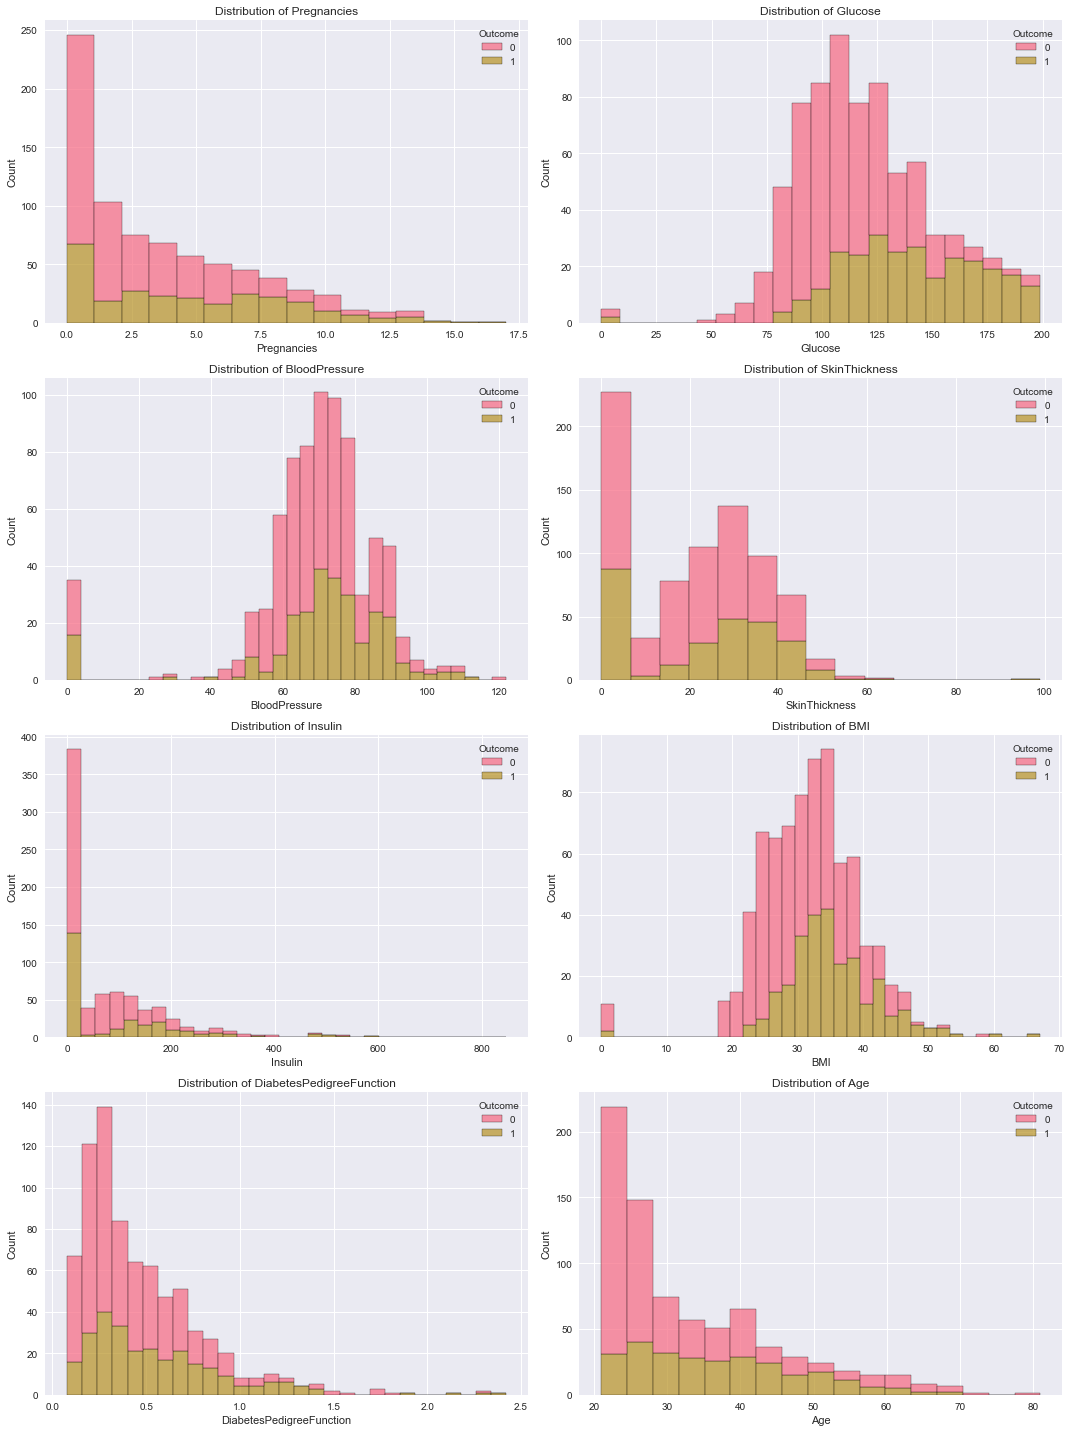

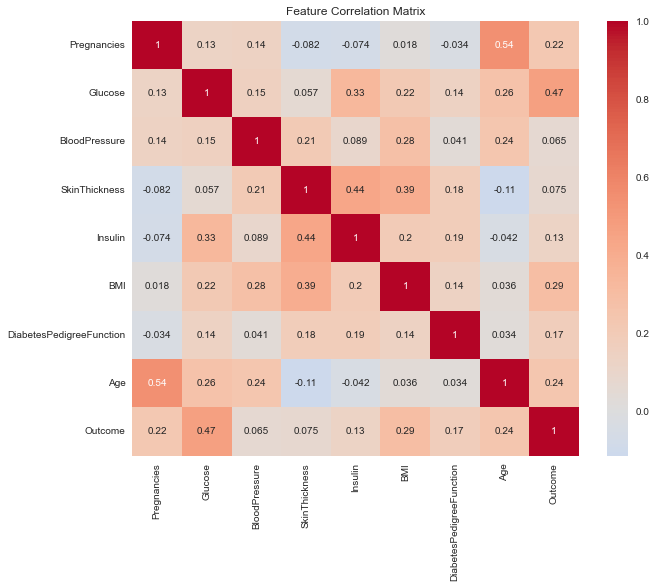


Zero Values Analysis:


,Column,Zero Count,Percentage
0,Glucose,5,0.65
1,BloodPressure,35,4.56
2,SkinThickness,227,29.56
3,Insulin,374,48.70
4,BMI,11,1.43


In [11]:
#Exploration des données
def explore_data(df):
    print("Dataset Shape:", df.shape)
    print("\nFirst few rows:")
    display(df.head())

    print("\nDataset Info:")
    display(df.info())

    print("\nStatistical Summary:")
    display(df.describe())

    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.ravel()

    for idx, col in enumerate(df.columns[:-1]):
        sns.histplot(data=df, x=col, hue='Outcome', multiple="stack", ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    zero_counts = df[zero_cols].eq(0).sum()
    zero_df = pd.DataFrame({
        'Column': zero_counts.index,
        'Zero Count': zero_counts.values,
        'Percentage': (zero_counts.values / len(df) * 100).round(2)
    })
    print("\nZero Values Analysis:")
    display(zero_df)

explore_data(df)


In [4]:
#Prétraitement des données
def preprocess_data(df, strategy='median'):
    df_processed = df.copy()
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    if strategy == 'median':
        for col in zero_cols:
            df_processed[col] = df_processed[col].replace(0, df_processed[col].median())
    elif strategy == 'mean':
        for col in zero_cols:
            df_processed[col] = df_processed[col].replace(0, df_processed[col].mean())

    X = df_processed.drop('Outcome', axis=1)
    y = df_processed['Outcome']

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X_scaled, y, scaler

X_scaled, y, scaler = preprocess_data(df)
X_scaled.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.031990,0.831114,-0.608201,0.167240,0.468492,1.425995
1,-0.844885,-1.205066,-0.528319,0.180566,-0.608201,-0.851551,-0.365061,-0.190672
2,1.233880,2.016662,-0.693761,-0.469981,-0.608201,-1.331838,0.604397,-0.105584
3,-0.844885,-1.073567,-0.528319,-0.469981,-0.006185,-0.633239,-0.920763,-1.041549
4,-1.141852,0.504422,-2.679076,0.831114,0.695378,1.549885,5.484909,-0.020496


In [12]:
#Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
#Entraînement des modèles
def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        results[name] = {
            'model': model,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        }

        print(f"\n{name} Results:")
        for metric, value in results[name].items():
            if metric != 'model' and value is not None:
                print(f"{metric}: {value:.3f}")

    return results

results = train_models(X_train, X_test, y_train, y_test)



Training Random Forest...

Random Forest Results:
accuracy: 0.760
precision: 0.681
recall: 0.593
f1: 0.634
auc: 0.821

Training Logistic Regression...

Logistic Regression Results:
accuracy: 0.708
precision: 0.600
recall: 0.500
f1: 0.545
auc: 0.815

Training SVM...

SVM Results:
accuracy: 0.727
precision: 0.636
recall: 0.519
f1: 0.571
auc: 0.795

Training KNN...

KNN Results:
accuracy: 0.708
precision: 0.596
recall: 0.519
f1: 0.554
auc: 0.760

Training Decision Tree...

Decision Tree Results:
accuracy: 0.669
precision: 0.533
recall: 0.444
f1: 0.485
auc: 0.617


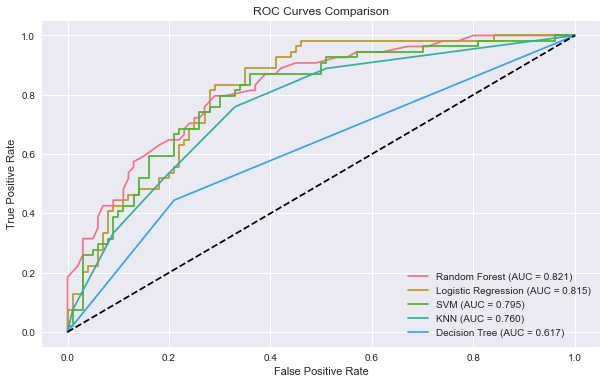

In [7]:
#Courbes ROC
def plot_roc_curves(results, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for name, result in results.items():
        model = result['model']
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.show()

plot_roc_curves(results, X_test, y_test)


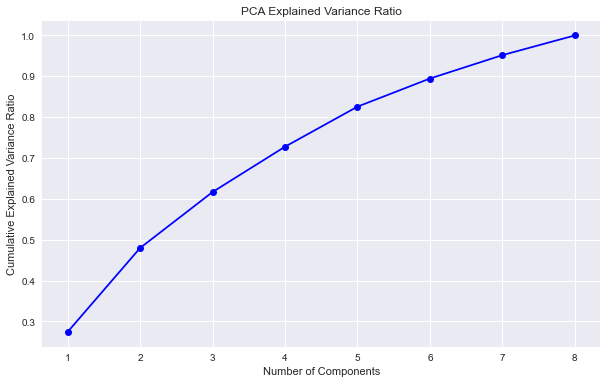

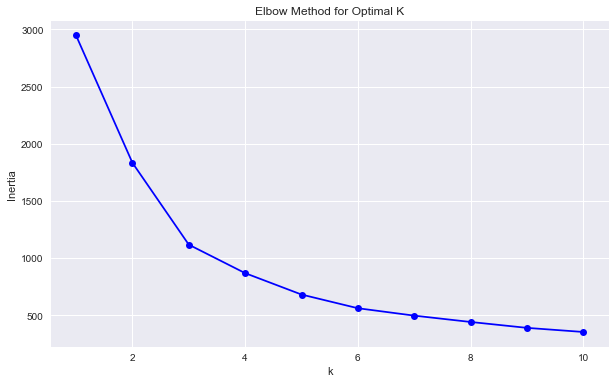

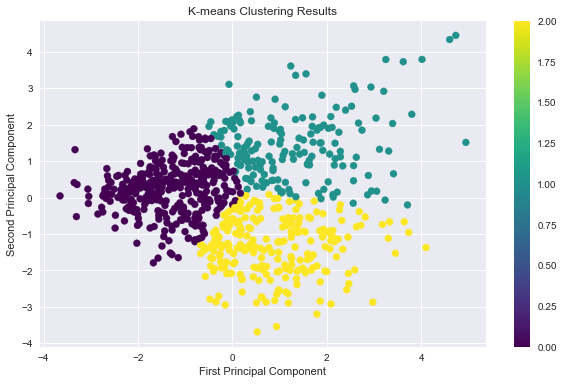

In [8]:
#Clustering avec PCA + KMeans
def perform_clustering(X_scaled):
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    X_pca_2d = PCA(n_components=2).fit_transform(X_scaled)

    inertias = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_pca_2d)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bo-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True)
    plt.show()

    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(X_pca_2d)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('K-means Clustering Results')
    plt.show()

    return clusters, X_pca_2d

clusters, X_pca_2d = perform_clustering(X_scaled)


In [9]:
#Faire une prédiction
def make_prediction(model, scaler, input_data):
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0]
    probability = model.predict_proba(input_scaled)[0] if hasattr(model, 'predict_proba') else None
    return prediction, probability

# Exemple : patient fictif
sample_patient = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]])
best_model = results['Random Forest']['model']
prediction, probability = make_prediction(best_model, scaler, sample_patient)

print("\nExample Prediction:")
print("Prediction:", "Diabetic" if prediction == 1 else "Non-Diabetic")
if probability is not None:
    print(f"Probability of being diabetic: {probability[1]:.3f}")



Example Prediction:
Prediction: Diabetic
Probability of being diabetic: 0.850
